In [13]:
!pwd

/


In [29]:
%cd /data/FoodDetection/Object_Detection/yolov5-test/yolov5/dataset

/data/FoodDetection/Object_Detection/yolov5-test/yolov5/dataset


1. for문으로 데이터프레임 합치기

https://hashcode.co.kr/questions/9219/%ED%8C%8C%EC%9D%B4%EC%8D%AC-for%EB%AC%B8-%EC%97%B0%EB%8F%84%EB%B3%84-%EB%B0%98%EB%B3%B5-%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%EC%83%9D%EC%84%B1


2. 데이터프레임 엑셀 시트별 저장

https://sromi.tistory.com/8

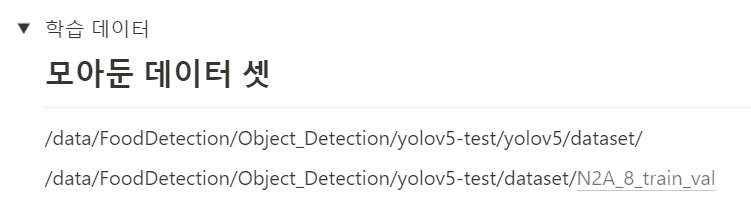

위의 경로 2곳에서 함수를 각각 실행시켜봐야한다!

# 함수

In [15]:
import re
import pandas as pd
import numpy as np
import os, glob
import shutil


df_total_list = pd.read_excel('class확정_20210707.xlsx', engine='openpyxl') # 엑셀 파일 로드
df_total_list = df_total_list.iloc[:,1:3].rename(columns={'라벨 인덱스':'class_number', 'FOOD_NM':'class_name'}) # 엑셀 컬럼 중 필요한 컬럼만 가져오기
df_total_list.dropna(inplace=True) # 널값 제거
df_total_list.class_number = df_total_list.class_number.astype(int) # class_number를 int로 변환

# 멀티레이블은 일단 안잡는다!

In [16]:
# class확정 엑셀 파일과 train,val폴더의 labels를 비교하는 함수
def check_data(dirs_name): # train, val 폴더들을 넣음.
    
    print(f'=========={dirs_name}==========')
    
    txt_classes = [] # txt 파일 안의 클래스를 담을 리스트.
    
    os.chdir(f'{dirs_name}/labels') # train, val 폴더안의 labels로 이동.
    des = os.getcwd()
    print(f'{dirs_name}/labels로 이동')
    files = os.listdir() # labels 폴더 내의 txt 파일들.
    print(f'{dirs_name}/labels 내의 txt 파일 개수: ', len(files))
#     print(files)
    
    
    empty_file = [] # 내용이 없는 file을 저장할 리스트
    
    for file in files: # for문으로 돌면서 txt 파일 하나씩 꺼냄.
        # txt 파일을 읽음.
        with open(file, "r") as f:
            text = f.read()
            # txt 파일 내용이 비어있을 경우, bin_txt 폴더에 'dirs_name이름_txt이름'으로 옮김.
            if text is "":
                empty_file.append(file)
                
###################### 빈 txt를 삭제하는 부분 #########################
###################### 처음에는 pass만 켜두고 #########################
######################## 실행해봐라!! #################################
#                 os.remove(f'{file}')
#                 if not os.path.exists('../../bin_txt'):
#                     os.makedirs('../../bin_txt')
#                 if not os.path.exists(f'../../bin_txt/{dirs_name}_bin_txt'):
#                     os.makedirs(f'../../bin_txt/{dirs_name}_bin_txt')
#                 os.chdir(f'../images')
#                 shutil.move(f'{file[:-3]}jpg', f'../../bin_txt/{dirs_name}_bin_txt')
#                 shutil.move(f'{file[:-3]}txt', f'../../bin_txt/{dirs_name}_bin_txt')
#                 os.chdir(f'../labels')
                pass
########################################################################


            # 내용이 있을 경우 정규표현식으로 내용의 첫 부분인 클래스만 추출
            else:
                p = re.compile(".*?\s")
                class_ = p.match(text).group()[:-1]
                # texts에 추출한 txt 저장
                txt_classes.append(class_)
    
    print('내용이 없는 txt 개수: ', len(empty_file))
    if len(empty_file) != 0:
        print(f'--{dirs_name}_bin_txt 폴더에 이동--')
    
    list_to_dict = {} # txt_classes의 '클래스_번호:개수'를 담을 딕셔너리
    
    # 내용이 있는 file들의 '클래스_번호:개수' 맵핑
    for text in txt_classes:
        if text in list_to_dict:
            list_to_dict[text] = list_to_dict[text]+1
        else:
            list_to_dict[text] = 1
    
    df = pd.DataFrame(list_to_dict.items(), columns=['class_number', 'counts']) # 딕셔너리를 데이터프레임으로 변환
    df.class_number = df.class_number.astype(int) # class_number를 int로 변환
    merge_df = pd.merge(df, df_total_list, on='class_number', how='left') # df_total_list와 병합
    merge_df = merge_df[['class_number', 'class_name', 'counts']] # 컬럼 순서 바꿈
    merge_df['folder'] = dirs_name # 폴더 이름 컬럼 추가
#     merge_df.to_excel(f'{dirs_name}.xlsx')


    # 폴더 안의 labels의 txt 파일들의 개수와 merge_df의 counts 개수가 일치하는지 확인!
    print(f'생성된 데이터프레임의 counts 개수: {len(files)}-{len(empty_file)} =', merge_df.counts.sum())
    if len(files)-len(empty_file) != merge_df.counts.sum():
        print('!!!!!!!!!!!!!!로드된 엑셀파일의 라벨 인덱스와 FOOD_NM에 이상이 있다!!!!!!!!!!')

    os.chdir(f'../..') # 현재 위치로 다시 이동
    print('\n')
    
    return merge_df



# check_data 함수실행 및 train_val 통합, 폴더 별로 엑셀 시트에 저장하는 함수

def execution():
    des = os.getcwd()
    des = des.split('/')[-1]
    print('현재 경로: ', des)
    print('')
    writer=pd.ExcelWriter(f'{des}.xlsx', engine='openpyxl')
    
    dirs = sorted(list(filter(os.path.isdir, glob.glob('*'))))
    train_list  = list(filter(lambda x: x.startswith('train'), dirs))
    val_list  = list(filter(lambda x: x.startswith('val'), dirs))
    train_val_list = train_list+val_list
    
    df_base= pd.DataFrame(columns=['class_number', 'class_name', 'counts'])
    
    for number, dir_ in enumerate(train_val_list):
        number = check_data(dir_)
        number = number[['class_number', 'class_name', 'counts']]
        number.to_excel(writer, sheet_name= f'{dir_}')
        df_base = pd.concat([df_base, number], axis=0, ignore_index=True)
        
    df_base.class_number = df_base.class_number.astype(int)
    df_base.counts = df_base.counts.astype(int)
    df_base = df_base.groupby('class_number').sum().reset_index()
    merge_df = pd.merge(df_base, df_total_list, on='class_number', how='left') # df_total_list와 병합
    merge_df = merge_df[['class_number', 'class_name', 'counts']] # 컬럼 순서 바꿈
    merge_df.to_excel(writer, sheet_name=f'train_val_total')
    writer.save()
    
    print('실행 완료')
    
    return merge_df

In [3]:
!pwd

/data/FoodDetection/Object_Detection/yolov5-test/yolov5/dataset


In [66]:
# %cd ../../yolov5/dataset

/data/FoodDetection/Object_Detection/yolov5-test/yolov5/dataset


In [4]:
# 실행
df1 = execution()
df1

현재 경로:  dataset

==========train1==========
train1/labels로 이동
train1/labels 내의 txt 파일 개수:  41924
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 41924-0 = 41924


==========train2==========
train2/labels로 이동
train2/labels 내의 txt 파일 개수:  89518
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 89518-0 = 89518


==========train3==========
train3/labels로 이동
train3/labels 내의 txt 파일 개수:  30675
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 30675-0 = 30675


==========train4==========
train4/labels로 이동
train4/labels 내의 txt 파일 개수:  3595
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 3595-0 = 3595


==========train5==========
train5/labels로 이동
train5/labels 내의 txt 파일 개수:  13188
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 13188-0 = 13188


==========train6==========
train6/labels로 이동
train6/labels 내의 txt 파일 개수:  3963
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 3963-0 = 3963


==========train7==========
train7/labels로 이동
train7/labels 내의 txt 파일 개수:  28507
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 28507-0 = 28507


==========train8

,class_number,class_name,counts
0,0,가리비구이,570
1,1,가자미구이,361
2,2,가자미조림,672
3,3,가지나물,801
4,4,가지냉국,595
...,...,...,...
694,696,파래야채튀김,165
695,697,콩나물무침,156
696,698,소고기 구이,403
697,700,피자,773


In [681]:
# 실행
execution()

==========train1==========
train1/labels로 이동
train1/labels 내의 txt 파일 개수:  41924
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 41924-0 = 41924


==========train2==========
train2/labels로 이동
train2/labels 내의 txt 파일 개수:  89518
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 89518-0 = 89518


==========train3==========
train3/labels로 이동
train3/labels 내의 txt 파일 개수:  30675
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 30675-0 = 30675


==========train4==========
train4/labels로 이동
train4/labels 내의 txt 파일 개수:  3595
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 3595-0 = 3595


==========train5==========
train5/labels로 이동
train5/labels 내의 txt 파일 개수:  13188
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 13188-0 = 13188


==========train6==========
train6/labels로 이동
train6/labels 내의 txt 파일 개수:  3963
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 3963-0 = 3963


==========train7==========
train7/labels로 이동
train7/labels 내의 txt 파일 개수:  28507
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 28507-0 = 28507


==========train8==========
train8

,class_number,class_name,counts
0,0,가리비구이,570
1,1,가자미구이,361
2,2,가자미조림,672
3,3,가지나물,801
4,4,가지냉국,595
...,...,...,...
694,696,파래야채튀김,165
695,697,콩나물무침,156
696,698,소고기 구이,403
697,700,피자,773


In [71]:
!pwd

/data/FoodDetection/Object_Detection/yolov5-test/yolov5/dataset


/data/FoodDetection/Object_Detection/yolov5-test/dataset/N2A_8_train_val로 이동

In [31]:
%cd ../../dataset/N2A_8_train_val

/data/FoodDetection/Object_Detection/yolov5-test/dataset/N2A_8_train_val


In [32]:
# 실행
df2 = execution()
df2

현재 경로:  N2A_8_train_val

==========train_N2A_8==========
train_N2A_8/labels로 이동
train_N2A_8/labels 내의 txt 파일 개수:  6542
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 6542-0 = 6542


==========val_N2A_8==========
val_N2A_8/labels로 이동
val_N2A_8/labels 내의 txt 파일 개수:  729
내용이 없는 txt 개수:  0
생성된 데이터프레임의 counts 개수: 729-0 = 729


실행 완료


,class_number,class_name,counts
0,20,곱창볶음,34
1,46,단무지,1
2,61,도토리묵무침,1
3,77,갈비탕,2
4,87,깍두기,1
5,94,더덕구이,1
6,97,된장찌개,1
7,98,라면,1
8,99,만두국,542
9,103,매생이국,4


N2A_8_train_val에서 새로 추가된 클래스 확인

In [7]:
set(df2.class_name.to_list()) - set(df1.class_name.to_list())

{'계란(달걀), 난황, 생것',
 '계란(달걀)국',
 '계란(달걀)덮밥',
 '곱창구이',
 '과메기',
 '닭찜,찜닭',
 '떡국',
 '메추리알조림',
 '부추, 산부추, 생것',
 '생선조림',
 '장어구이',
 '장어덮밥'}

In [8]:
total = pd.concat([df1, df2], ignore_index=True).groupby('class_number').sum()
total

,counts
class_number,
0,570
1,361
2,672
3,801
4,595
...,...
811,861
822,925
824,863


In [9]:
merge_df = pd.merge(total, df_total_list, on='class_number', how='left') # df_total_list와 병합
merge_df = merge_df[['class_number', 'class_name', 'counts']] # 컬럼 순서 바꿈
merge_df

,class_number,class_name,counts
0,0,가리비구이,570
1,1,가자미구이,361
2,2,가자미조림,672
3,3,가지나물,801
4,4,가지냉국,595
...,...,...,...
706,811,계란(달걀)국,861
707,822,곱창구이,925
708,824,과메기,863
709,825,생선조림,771


In [24]:
merge_df[merge_df.class_name=='떡국']

,class_number,class_name,counts
705,810,떡국,354


In [23]:
merge_df[merge_df.class_name.isnull()]

,class_number,class_name,counts
63,63,NaN,1007
264,264,NaN,348
266,266,NaN,294
283,283,NaN,217
284,284,NaN,164
285,285,NaN,194
321,321,NaN,296
328,328,NaN,324
330,330,NaN,274


In [22]:
merge_df[merge_df.class_name.duplicated()]
# duplicated는 하나가 빠져서 나온다!

,class_number,class_name,counts
264,264,NaN,348
266,266,NaN,294
283,283,NaN,217
284,284,NaN,164
285,285,NaN,194
321,321,NaN,296
328,328,NaN,324
330,330,NaN,274


In [86]:
!pwd

/data/FoodDetection/Object_Detection/yolov5-test/dataset/N2A_8_train_val


In [88]:
merge_df.to_excel('dataset+N2A.xlsx')

# '/Data/FoodDetection/data/food_detection/음식인식2차' 경로

In [9]:
%cd ..

/


In [10]:
!ls

bin   data  etc   lib	 media	opt   root  sbin  sys  usr
boot  dev   home  lib64  mnt	proc  run   srv   tmp  var


/data와 /Data는 만날 수가 없구나ㅠㅠ

# 떡국 이미지 10장 뽑아라!

/data/FoodDetection/Object_Detection/yolov5-test/dataset/N2A_8_train_val/train_N2A_8/images

경로이다.

In [57]:
%cd /data/FoodDetection/Object_Detection/yolov5-test/dataset/N2A_8_train_val/train_N2A_8/labels

/data/FoodDetection/Object_Detection/yolov5-test/dataset/N2A_8_train_val/train_N2A_8/labels


In [52]:
!pwd

/data/FoodDetection/Object_Detection/yolov5-test/dataset/N2A_8_train_val/train_N2A_8/images


In [58]:
떡국들 = []

files = os.listdir()
for file in files:
    with open(file, "r") as f:
        text = f.read()
        print(file)
        print(text)
        p = re.compile(".*?\s")
        class_ = p.match(text).group()[:-1]
        print(class_)
        print('=============')
        if class_ == '810':
            떡국들.append(file)
            
print('떡국 txt: ', 떡국들)

current_path = './'
new_path = '../떡국_10장'
if not os.path.exists(new_path):
    os.mkdir(new_path)

os.chdir('../images/')

# 파일 복사해서 옮기기!
# https://ansan-survivor.tistory.com/917

files = os.listdir()
for file in files:
    for 떡국 in 떡국들:
        if file[:-3] ==  떡국[:-3]:
            shutil.copy(file, new_path)
            print('"{}" has been copied in new folder!'.format(file))
            
os.chdir('../labels/')

Img_003_0000.txt
822 0.505804 0.560000 0.951907 0.860000

822
Img_003_0001.txt
822 0.540084 0.500000 0.683544 0.875000

822
Img_003_0003.txt
20 0.500865 0.501250 0.998270 0.997500

20
Img_003_0004.txt
20 0.501667 0.491250 0.996667 0.737500

20
Img_003_0006.txt
822 0.471667 0.520000 0.743333 0.805000

822
Img_003_0007.txt
822 0.452658 0.448750 0.327243 0.392500

822
Img_003_0008.txt
822 0.367089 0.151250 0.616034 0.297500

822
Img_003_0009.txt
822 0.439286 0.638750 0.846429 0.442500

822
Img_003_0010.txt
822 0.325041 0.587500 0.487562 0.665000
780 0.686567 0.620000 0.285240 0.550000

822
Img_003_0013.txt
822 0.562588 0.525000 0.483826 0.660000

822
Img_003_0014.txt
822 0.549930 0.567500 0.812940 0.865000

822
Img_003_0015.txt
822 0.501406 0.522500 0.552743 0.620000

822
Img_003_0017.txt
822 0.476744 0.578750 0.578073 0.687500

822
Img_003_0018.txt
822 0.488372 0.447500 0.149502 0.275000

822
Img_003_0019.txt
822 0.497508 0.455000 0.184385 0.210000

822
Img_003_0021.txt
822 0.462625 0.61

822
Img_003_0479.txt
822 0.598333 0.486250 0.376667 0.662500

822
Img_003_0480.txt
822 0.588870 0.406250 0.513289 0.732500
166 0.263289 0.550000 0.224252 0.540000
437 0.924419 0.630000 0.151163 0.425000

822
Img_003_0482.txt
822 0.460000 0.402500 0.310000 0.320000

822
Img_003_0483.txt
822 0.605833 0.395000 0.418333 0.490000
166 0.332500 0.555000 0.231667 0.395000

822
Img_003_0484.txt
822 0.500000 0.456250 0.286667 0.377500

822
Img_003_0485.txt
822 0.527409 0.522500 0.938538 0.950000

822
Img_003_0486.txt
822 0.497500 0.430000 0.418333 0.420000

822
Img_003_0487.txt
822 0.529167 0.520000 0.435000 0.395000

822
Img_003_0488.txt
822 0.498333 0.405000 0.340000 0.520000

822
Img_003_0489.txt
822 0.472500 0.540000 0.608333 0.850000

822
Img_003_0490.txt
822 0.540833 0.378750 0.251667 0.382500

822
Img_003_0491.txt
822 0.515000 0.415000 0.266667 0.335000

822
Img_003_0492.txt
822 0.762500 0.521250 0.475000 0.817500
822 0.086667 0.687500 0.130000 0.225000
166 0.403333 0.645000 0.420000 0.31


822
Img_003_0875.txt
822 0.174484 0.428750 0.318949 0.467500
822 0.390244 0.140000 0.416510 0.210000
822 0.796435 0.360000 0.407129 0.505000
822 0.371482 0.735000 0.491557 0.530000

822
Img_003_0877.txt
822 0.431542 0.491250 0.616984 0.622500
166 0.311092 0.826250 0.618718 0.347500

822
Img_003_0878.txt
822 0.484053 0.497500 0.926829 0.950000

822
Img_003_0879.txt
822 0.493433 0.501250 0.930582 0.997500

822
Img_003_0880.txt
822 0.483114 0.217500 0.377111 0.175000
437 0.510319 0.608750 0.225141 0.212500

822
Img_003_0881.txt
822 0.630394 0.448750 0.667917 0.867500
166 0.242964 0.497500 0.328330 0.320000
437 0.556285 0.168750 0.294559 0.112500

822
Img_003_0882.txt
822 0.587242 0.415000 0.780488 0.780000

822
Img_003_0883.txt
822 0.381667 0.405000 0.453333 0.535000

822
Img_003_0884.txt
822 0.434167 0.568750 0.668333 0.507500

822
Img_003_0885.txt
822 0.263602 0.532500 0.523452 0.410000

822
Img_003_0886.txt
822 0.505629 0.448750 0.988743 0.847500

822
Img_003_0887.txt
822 0.525748 0.5

198 0.501667 0.547778 0.970000 0.464444

198
Img_009_0293.txt
198 0.512780 0.539024 0.616613 0.575610

198
Img_009_0294.txt
198 0.531818 0.487379 0.567532 0.714563

198
Img_009_0295.txt
198 0.517708 0.513889 0.964583 0.727778

198
Img_009_0297.txt
198 0.578500 0.507117 0.569000 0.985765

198
Img_009_0298.txt
198 0.461698 0.594720 0.749482 0.236025
714 0.836957 0.444876 0.326087 0.218944
714 0.796584 0.815217 0.406832 0.369565

198
Img_009_0299.txt
714 0.318103 0.764368 0.508621 0.443678
714 0.531897 0.117241 0.301724 0.188506
198 0.728448 0.737931 0.305172 0.409195
198 0.802586 0.179310 0.246552 0.239080
437 0.697414 0.402299 0.153448 0.193103

714
Img_009_0300.txt
714 0.460000 0.820359 0.868000 0.359281
714 0.635000 0.471557 0.710000 0.565868
198 0.512000 0.619760 0.880000 0.532934
198 0.573000 0.199102 0.554000 0.392216

714
Img_009_0301.txt
714 0.396094 0.714063 0.570312 0.471875
130 0.268750 0.392969 0.193750 0.123438
108 0.582031 0.353906 0.189062 0.135937
405 0.448437 0.246875 0.

Img_009_0726.txt
714 0.518333 0.516250 0.956667 0.737500

714
Img_009_0727.txt
714 0.765478 0.481250 0.228893 0.927500
198 0.278612 0.530000 0.395872 0.620000

714
Img_009_0728.txt
198 0.730858 0.488750 0.510441 0.507500
714 0.291183 0.607500 0.359629 0.500000

198
Img_009_0729.txt
714 0.676667 0.328750 0.646667 0.572500
198 0.350000 0.546250 0.580000 0.547500

714
Img_009_0730.txt
714 0.493333 0.563750 0.880000 0.717500

714
Img_009_0731.txt
714 0.545000 0.315000 0.550000 0.450000
198 0.586667 0.655000 0.613333 0.490000

714
Img_009_0732.txt
198 0.532860 0.587500 0.696270 0.430000
714 0.539076 0.312500 0.651865 0.180000
71 0.158970 0.215000 0.129663 0.160000
523 0.291297 0.141250 0.142096 0.152500

198
Img_009_0733.txt
198 0.498127 0.486250 0.876404 0.867500

198
Img_009_0734.txt
198 0.509167 0.595000 0.845000 0.325000
714 0.513333 0.336250 0.880000 0.287500

198
Img_009_0735.txt
714 0.517500 0.467500 0.871667 0.515000

714
Img_009_0738.txt
198 0.529851 0.581250 0.940299 0.837500

198

Img_014_0260.txt
811 0.716000 0.558559 0.560000 0.426426

811
Img_014_0261.txt
811 0.499081 0.475899 0.629289 0.742647

811
Img_014_0262.txt
811 0.448183 0.543522 0.414536 0.645749

811
Img_014_0263.txt
811 0.516406 0.512500 0.701562 0.775000

811
Img_014_0265.txt
811 0.553333 0.492000 0.824000 0.916000

811
Img_014_0267.txt
811 0.750000 0.536486 0.500000 0.818919

811
Img_014_0268.txt
801 0.503125 0.570981 0.490625 0.503132
811 0.228906 0.078288 0.307812 0.118998

801
Img_014_0269.txt
811 0.512500 0.552500 0.481667 0.490000

811
Img_014_0271.txt
811 0.498125 0.385116 0.456250 0.203757

811
Img_014_0273.txt
811 0.710135 0.503604 0.579730 0.790991

811
Img_014_0275.txt
811 0.372656 0.568235 0.645312 0.863529

811
Img_014_0276.txt
811 0.525000 0.535000 0.590000 0.735000

811
Img_014_0277.txt
811 0.531818 0.460383 0.598182 0.461749

811
Img_014_0278.txt
811 0.520270 0.500901 0.497297 0.554955

811
Img_014_0279.txt
811 0.509225 0.502930 0.564576 0.353516

811
Img_014_0280.txt
811 0.228129 

Img_014_0932.txt
811 0.558052 0.677500 0.711610 0.325000

811
Img_014_0933.txt
811 0.500000 0.487500 0.573333 0.600000

811
Img_014_0935.txt
811 0.435726 0.651250 0.737896 0.697500

811
Img_014_0936.txt
811 0.515009 0.455000 0.564728 0.560000

811
Img_014_0937.txt
811 0.551237 0.546250 0.809187 0.907500

811
Img_014_0939.txt
811 0.574167 0.548750 0.375000 0.502500

811
Img_014_0940.txt
811 0.553068 0.573750 0.442786 0.667500

811
Img_014_0941.txt
811 0.434701 0.533750 0.727612 0.442500

811
Img_014_0942.txt
811 0.591667 0.496250 0.616667 0.692500

811
Img_014_0943.txt
811 0.651250 0.496250 0.697500 0.497500

811
Img_014_0944.txt
811 0.499062 0.552500 0.525328 0.825000

811
Img_014_0947.txt
811 0.496678 0.470000 0.435216 0.495000

811
Img_014_0949.txt
811 0.550833 0.475000 0.545000 0.660000

811
Img_014_0950.txt
811 0.441176 0.510000 0.592157 0.690000

811
Img_014_0951.txt
811 0.445032 0.442500 0.378436 0.235000

811
Img_014_0952.txt
811 0.472408 0.498750 0.489967 0.547500

811
Img_014_

Img_015_0393.txt
810 0.406364 0.225532 0.340000 0.146809
708 0.678182 0.081383 0.290909 0.096809
99 0.529091 0.693085 0.545455 0.237234

810
Img_015_0394.txt
99 0.511905 0.454483 0.959627 0.784828

99
Img_015_0395.txt
99 0.519286 0.557878 0.961429 0.817792

99
Img_015_0396.txt
99 0.507059 0.514706 0.985882 0.970588

99
Img_015_0398.txt
810 0.492147 0.538310 0.458115 0.656189

810
Img_015_0399.txt
99 0.457432 0.489837 0.677027 0.727642

99
Img_015_0400.txt
99 0.502033 0.674324 0.695122 0.335135
99 0.218496 0.357432 0.331301 0.136486
130 0.831301 0.451351 0.308943 0.159459

99
Img_015_0401.txt
99 0.338939 0.598398 0.608021 0.610984

99
Img_015_0402.txt
99 0.495270 0.458716 0.704054 0.834862

99
Img_015_0403.txt
810 0.515000 0.507163 0.845000 0.739255

810
Img_015_0405.txt
99 0.605051 0.621131 0.789899 0.493943

99
Img_015_0406.txt
99 0.511719 0.519444 0.679688 0.650000

99
Img_015_0407.txt
810 0.579843 0.444008 0.840314 0.880157

810
Img_015_0408.txt
99 0.533621 0.522989 0.787931 0.72413

Img_015_0730.txt
98 0.547264 0.511250 0.484245 0.677500

98
Img_015_0731.txt
810 0.504167 0.485000 0.745000 0.880000

810
Img_015_0732.txt
810 0.511236 0.570000 0.782772 0.440000

810
Img_015_0733.txt
99 0.505682 0.563750 0.545455 0.477500

99
Img_015_0734.txt
99 0.536975 0.510000 0.838655 0.770000

99
Img_015_0735.txt
300 0.475166 0.506250 0.784768 0.742500

300
Img_015_0737.txt
810 0.506329 0.506250 0.632911 0.677500

810
Img_015_0738.txt
99 0.535000 0.506250 0.906667 0.892500

99
Img_015_0739.txt
99 0.557665 0.585000 0.881857 0.830000

99
Img_015_0740.txt
99 0.539381 0.612500 0.735584 0.775000

99
Img_015_0741.txt
810 0.395000 0.508750 0.770000 0.982500

810
Img_015_0742.txt
99 0.526667 0.511250 0.673333 0.977500

99
Img_015_0745.txt
810 0.765478 0.563750 0.454034 0.452500
810 0.135084 0.430000 0.266417 0.335000
214 0.520638 0.218750 0.264540 0.287500

810
Img_015_0746.txt
99 0.510242 0.572500 0.729981 0.745000

99
Img_015_0747.txt
99 0.509136 0.570000 0.420266 0.445000

99
Img_015_

825
Img_022_0262.txt
825 0.498342 0.496250 0.993367 0.987500

825
Img_022_0263.txt
825 0.435323 0.528750 0.681592 0.662500

825
Img_022_0264.txt
825 0.505833 0.276250 0.985000 0.532500

825
Img_022_0265.txt
825 0.520695 0.545000 0.938742 0.675000

825
Img_022_0266.txt
825 0.564728 0.537500 0.634146 0.460000

825
Img_022_0267.txt
825 0.337500 0.682500 0.280000 0.295000
415 0.718750 0.325000 0.337500 0.280000

825
Img_022_0268.txt
825 0.137131 0.876250 0.270042 0.237500

825
Img_022_0270.txt
825 0.497326 0.556250 0.894831 0.817500

825
Img_022_0271.txt
825 0.501511 0.523750 0.996979 0.802500

825
Img_022_0272.txt
825 0.488372 0.500000 0.973166 0.885000

825
Img_022_0274.txt
825 0.503436 0.545000 0.993127 0.785000

825
Img_022_0276.txt
825 0.481039 0.505000 0.956461 0.980000

825
Img_022_0278.txt
825 0.500938 0.500000 0.994371 0.990000

825
Img_022_0279.txt
825 0.404315 0.770000 0.260788 0.345000
437 0.182927 0.282500 0.114447 0.115000
415 0.650094 0.492500 0.144465 0.270000
383 0.530957 


779
Img_112_0004.txt
779 0.496875 0.462441 0.675000 0.859155

779
Img_112_0006.txt
779 0.786486 0.665714 0.294595 0.379048
401 0.247973 0.674286 0.295946 0.388571

779
Img_112_0007.txt
779 0.463768 0.536491 0.759834 0.861801

779
Img_112_0008.txt
779 0.504687 0.468750 0.696875 0.645833

779
Img_112_0009.txt
779 0.493077 0.416859 0.540000 0.436490

779
Img_112_0010.txt
779 0.645714 0.513859 0.294286 0.695096
168 0.320000 0.636461 0.462857 0.479744

779
Img_112_0011.txt
779 0.501667 0.490000 0.756667 0.700000

779
Img_112_0013.txt
779 0.483108 0.523327 0.482432 0.539554

779
Img_112_0014.txt
779 0.520833 0.436813 0.787500 0.796703

779
Img_112_0015.txt
779 0.486333 0.492952 0.638000 0.695154

779
Img_112_0016.txt
779 0.495000 0.505208 0.718571 0.656250

779
Img_112_0017.txt
779 0.446333 0.501185 0.620667 0.997630

779
Img_112_0018.txt
779 0.607477 0.490982 0.785047 0.873747

779
Img_112_0019.txt
779 0.495690 0.524611 0.625862 0.816062

779
Img_112_0021.txt
779 0.492708 0.506726 0.852083

779
Img_112_0462.txt
779 0.398973 0.523750 0.763699 0.512500

779
Img_112_0463.txt
779 0.488743 0.786250 0.545966 0.267500
401 0.483114 0.458750 0.594747 0.457500

779
Img_112_0464.txt
779 0.534628 0.442500 0.545608 0.445000

779
Img_112_0465.txt
779 0.357500 0.522500 0.591667 0.705000

779
Img_112_0466.txt
779 0.507634 0.428750 0.438931 0.512500

779
Img_112_0467.txt
779 0.482500 0.586250 0.555000 0.557500

779
Img_112_0468.txt
779 0.497500 0.435000 0.588333 0.340000

779
Img_112_0469.txt
779 0.521576 0.500000 0.637899 0.505000

779
Img_112_0470.txt
779 0.542500 0.538750 0.501667 0.587500

779
Img_112_0471.txt
779 0.526316 0.523750 0.902256 0.302500

779
Img_112_0472.txt
779 0.533835 0.577500 0.842105 0.270000

779
Img_112_0473.txt
779 0.463333 0.523750 0.410000 0.422500

779
Img_112_0475.txt
779 0.490602 0.597500 0.973684 0.305000

779
Img_112_0476.txt
779 0.492481 0.583750 0.947368 0.407500

779
Img_112_0477.txt
779 0.340824 0.632500 0.486891 0.145000
685 0.767790 0.523750 0.464419 

Img_112_0998.txt
779 0.415000 0.446250 0.700000 0.667500

779
Img_112_0999.txt
779 0.478333 0.553750 0.343333 0.617500

779
Img_112_1000.txt
779 0.577500 0.566250 0.608333 0.797500

779
Img_132_0000.txt
719 0.481360 0.462882 0.899123 0.422125

719
Img_132_0001.txt
719 0.496000 0.629129 0.628000 0.519520
688 0.184000 0.252252 0.196000 0.126126
708 0.382000 0.165165 0.172000 0.102102
130 0.596000 0.211712 0.128000 0.087087

719
Img_132_0002.txt
719 0.491176 0.526895 0.667647 0.946210

719
Img_132_0003.txt
719 0.475000 0.473581 0.798571 0.720157

719
Img_132_0004.txt
719 0.490000 0.516667 0.977778 0.893333

719
Img_132_0006.txt
719 0.530312 0.565417 0.939375 0.869167

719
Img_132_0007.txt
719 0.488756 0.512953 0.929535 0.953368

719
Img_132_0008.txt
719 0.501818 0.590964 0.996364 0.543373

719
Img_132_0009.txt
719 0.504167 0.500000 0.851667 0.782222

719
Img_132_0010.txt
719 0.490625 0.519792 0.890625 0.877083

719
Img_132_0011.txt
719 0.581841 0.488889 0.836319 0.962963

719
Img_132_0013

Img_132_0453.txt
719 0.663725 0.525240 0.580392 0.810096

719
Img_132_0454.txt
719 0.510938 0.523438 0.978125 0.862500

719
Img_132_0458.txt
719 0.483829 0.502304 0.918499 0.921659

719
Img_132_0460.txt
719 0.597826 0.579710 0.731884 0.565217
259 0.727226 0.108178 0.106625 0.075569
122 0.494824 0.095756 0.169772 0.059006

719
Img_132_0462.txt
719 0.480469 0.484375 0.859375 0.859375

719
Img_132_0463.txt
719 0.531250 0.531250 0.818750 0.875000

719
Img_132_0464.txt
719 0.383889 0.480801 0.743333 0.814691

719
Img_132_0465.txt
719 0.515625 0.543750 0.943750 0.912500

719
Img_132_0466.txt
719 0.617769 0.601660 0.764463 0.796680
130 0.146006 0.117220 0.143251 0.163900

719
Img_132_0467.txt
719 0.513423 0.515444 0.973154 0.969112

719
Img_132_0468.txt
719 0.710938 0.445312 0.528125 0.553125
708 0.159375 0.346875 0.193750 0.137500
130 0.190625 0.579688 0.187500 0.128125

719
Img_132_0469.txt
719 0.425926 0.499382 0.807407 0.739184

719
Img_132_0470.txt
719 0.578579 0.478228 0.688689 0.427928

Img_145_0323.txt
824 0.533276 0.438750 0.933447 0.847500

824
Img_145_0325.txt
824 0.399213 0.621250 0.325984 0.592500

824
Img_145_0327.txt
824 0.490654 0.512500 0.936449 0.915000

824
Img_145_0328.txt
824 0.484167 0.475000 0.631667 0.580000

824
Img_145_0329.txt
824 0.505000 0.497500 0.990000 0.985000

824
Img_145_0330.txt
824 0.325000 0.687500 0.436667 0.625000
824 0.563333 0.557500 0.456667 0.665000
824 0.765000 0.421250 0.423333 0.637500

824
Img_145_0331.txt
824 0.474167 0.577500 0.565000 0.645000
824 0.617500 0.317500 0.558333 0.530000
824 0.307500 0.732500 0.611667 0.535000

824
Img_145_0332.txt
824 0.708333 0.627500 0.583333 0.625000

824
Img_145_0333.txt
824 0.524086 0.558750 0.353821 0.722500

824
Img_145_0334.txt
824 0.540000 0.477500 0.830000 0.880000

824
Img_145_0335.txt
824 0.714167 0.405000 0.278333 0.330000
824 0.444167 0.716250 0.191667 0.257500
824 0.645000 0.758750 0.140000 0.237500

824
Img_145_0336.txt
824 0.429644 0.553750 0.634146 0.617500

824
Img_145_0338.txt

"Img_015_0003.jpg" has been copied in new folder!
"Img_015_0006.jpg" has been copied in new folder!
"Img_015_0008.jpg" has been copied in new folder!
"Img_015_0010.jpg" has been copied in new folder!
"Img_015_0012.jpg" has been copied in new folder!
"Img_015_0015.jpg" has been copied in new folder!
"Img_015_0016.jpg" has been copied in new folder!
"Img_015_0017.jpg" has been copied in new folder!
"Img_015_0018.jpg" has been copied in new folder!
"Img_015_0019.jpg" has been copied in new folder!
"Img_015_0020.jpg" has been copied in new folder!
"Img_015_0023.jpg" has been copied in new folder!
"Img_015_0024.jpg" has been copied in new folder!
"Img_015_0025.jpg" has been copied in new folder!
"Img_015_0026.jpg" has been copied in new folder!
"Img_015_0027.jpg" has been copied in new folder!
"Img_015_0028.jpg" has been copied in new folder!
"Img_015_0029.jpg" has been copied in new folder!
"Img_015_0030.jpg" has been copied in new folder!
"Img_015_0031.jpg" has been copied in new folder!


"Img_015_0547.jpg" has been copied in new folder!
"Img_015_0551.jpg" has been copied in new folder!
"Img_015_0552.jpg" has been copied in new folder!
"Img_015_0557.jpg" has been copied in new folder!
"Img_015_0560.jpg" has been copied in new folder!
"Img_015_0562.jpg" has been copied in new folder!
"Img_015_0563.jpg" has been copied in new folder!
"Img_015_0565.jpg" has been copied in new folder!
"Img_015_0571.jpg" has been copied in new folder!
"Img_015_0572.jpg" has been copied in new folder!
"Img_015_0580.jpg" has been copied in new folder!
"Img_015_0584.jpg" has been copied in new folder!
"Img_015_0587.jpg" has been copied in new folder!
"Img_015_0594.jpg" has been copied in new folder!
"Img_015_0597.jpg" has been copied in new folder!
"Img_015_0598.jpg" has been copied in new folder!
"Img_015_0600.jpg" has been copied in new folder!
"Img_015_0602.jpg" has been copied in new folder!
"Img_015_0603.jpg" has been copied in new folder!
"Img_015_0607.jpg" has been copied in new folder!
